## VTC Evaluation Steps

In [12]:
from pathlib import Path
import pandas as pd
import pickle
from pyannote.core import Annotation, Segment
from pyannote.metrics.detection import DetectionPrecisionRecallFMeasure, DetectionErrorRate
from typing import List
import logging
import matplotlib.pyplot as plt
from src.constants import VTCPaths

def plot_annotations_vs_predictions(audio_file_name: str, hypothesis_type: str, time_window: list) -> None:
    """
    Plot ground truth annotations and model predictions for a given audio file and time window.

    Parameters
    ----------
    audio_file_name : str
        The name of the audio file
    hypothesis_type : str
        Hypothesis type: 'og', 'ft', or 'cl'.
    time_window : list
        Start and end time for the plot: [start_time, end_time].
    """
    gt_df = pd.read_pickle(VTCPaths.childlens_gt_df_file_path)

    hypothesis_paths = {
        'og': '/home/nele_pauline_suffo/outputs/vtc/childlens_df_og.pkl',
        'ft': '/home/nele_pauline_suffo/outputs/vtc_finetuned/childlens_df_ft.pkl',
        'cl': '/home/nele_pauline_suffo/outputs/vtc_from_scratch/childlens_df_cl.pkl'
    }
    if hypothesis_type not in hypothesis_paths:
        raise ValueError("Invalid hypothesis type. Choose from 'og', 'ft', or 'cl'.")

    hypothesis_df = pd.read_pickle(hypothesis_paths[hypothesis_type])

    # Normalize label format
    gt_df['Voice_type'] = gt_df['Voice_type'].replace({'OCH': 'CHI'})
    hypothesis_df['Voice_type'] = hypothesis_df['Voice_type'].str.upper().replace({'OCH': 'CHI'})

    # Filter relevant audio file
    gt = gt_df[gt_df['audio_file_name'] == audio_file_name]
    pred = hypothesis_df[hypothesis_df['audio_file_name'] == audio_file_name]

    voice_types = ['KCHI', 'CHI', 'FEM', 'MAL', 'SPEECH']
    colors = {'GT': 'green', 'Pred': 'blue'}

    # Set up the plot
    plt.figure(figsize=(10, 2.75))  # Increased height for more vertical space
    ax = plt.gca()

    row_step = 2  # Increase this value to add more vertical spacing
    yticks = []
    ylabels = []

    for i, vt in enumerate(voice_types[::-1]):  # Reverse order for stacking
        base_y = i * row_step
        for offset, (source_df, label_prefix) in enumerate([(gt, 'GT'), (pred, 'Pred')]):
            y_pos = base_y + offset
            for _, row in source_df[source_df['Voice_type'] == vt].iterrows():
                ax.barh(
                    y=y_pos,
                    width=row['Utterance_Duration'],
                    left=row['Utterance_Start'],
                    color=colors[label_prefix],
                    edgecolor='black',
                    alpha=0.7
                )
            yticks.append(y_pos)
            ylabels.append(f"{label_prefix} {vt}")

    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Category")
    ax.set_title("Annotations vs Predictions")
    ax.set_xlim(time_window[0], time_window[1])
    ax.set_ylim(-1, max(yticks) + 2)
    plt.tight_layout()
    plt.show()
    
def combine_pickles(folder_path: str, output_file_name: str) -> None:
    """
    Combines all pickle files in a folder into a single DataFrame and saves it to a new pickle file.

    Parameters:
    - folder_path (str): Path to the folder containing the pickle files.
    - output_path (str): Path to save the combined DataFrame as a pickle file.
    """
    # List to store individual DataFrames
    dataframes = []

    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.pkl'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'rb') as f:
                df = pickle.load(f)
                dataframes.append(df)

    # Combine all DataFrames into one
    combined_df = pd.concat(dataframes, ignore_index=True)

    output_path = os.path.join(folder_path, output_file_name)
    combined_df.to_pickle(output_path)
    
def rttm_to_dataframe(rttm_file: Path, output_path: Path) -> pd.DataFrame:
    """
    This function reads the voice_type_classifier
    output rttm file and returns its content as a pandas DataFrame.

    Parameters
    ----------
    rttm_file : path
        the path to the RTTM file
    output_path: path
        the path to the output pkl file

    """
    logging.info(f"Reading RTTM file from: {rttm_file}")
    
    try:
        df = pd.read_csv(
            rttm_file,
            sep=" ",
            names=[
                "Speaker",
                "audio_file_name",
                "audio_file_id",
                "Utterance_Start",
                "Utterance_Duration",
                "NA_1",
                "NA_2",
                "Voice_type",
                "NA_3",
                "NA_4",
            ],
        )
    except Exception as e:
        logging.error(f"Failed to read RTTM file: {e}")
        raise
    
    logging.info("Successfully read RTTM file. Processing data...")

    # Drop unnecessary columns
    df = df.drop(columns=["Speaker", "audio_file_id", "NA_1", "NA_2", "NA_3", "NA_4"])  # noqa: E501
    df["Utterance_End"] = df["Utterance_Start"] + df["Utterance_Duration"]
    
    logging.info("Data processing complete. Returning DataFrame.")

    try:
        df.to_pickle(output_path)
        logging.info(f"DataFrame successfully saved to: {output_path}")
    except Exception as e:
        logging.error(f"Failed to save DataFrame to file: {e}")
        raise

def dataframe_to_annotation(df, label_column="Voice_type"):
    """
    Converts a DataFrame to a pyannote.core.Annotation object.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with 'Utterance_Start', 'Utterance_End', and a label column.
    - label_column (str): Column name for the labels (default: 'Voice_type').

    Returns:
    - Annotation: pyannote.core.Annotation object.
    """
    annotation = Annotation()
    for _, row in df.iterrows():
        start = float(row["Utterance_Start"])
        end = float(row["Utterance_End"])
        label = row[label_column]
        annotation[Segment(start, end)] = label
    return annotation

def compute_metrics(hypothesis_type: str) -> None:
    """
    Computes and prints the detection metrics for the given hypothesis type.
    Parameters
    ----------
    hypothesis_type : str
        The type of hypothesis to compute metrics for. Options are 'og', 'ft', or 'cl'.
    """
    hypothesis_paths = {
        'og': Path('/home/nele_pauline_suffo/outputs/vtc/childlens_df_og.pkl'),
        'ft': Path('/home/nele_pauline_suffo/outputs/vtc_finetuned/childlens_df_ft.pkl'),
        'cl': Path('/home/nele_pauline_suffo/outputs/vtc_from_scratch/childlens_df_cl.pkl')
    }
    if hypothesis_type not in hypothesis_paths:
        raise ValueError("Invalid hypothesis type. Choose 'og', 'ft', or 'cl'.")
    
    hypothesis_path = hypothesis_paths[hypothesis_type]

    reference_df = pd.read_pickle(VTCPaths.childlens_gt_df_file_path)
    hypothesis_df = pd.read_pickle(hypothesis_path)
    
    # Normalize labels
    reference_df['Voice_type'] = reference_df['Voice_type'].replace({'OCH': 'CHI'})
    hypothesis_df['Voice_type'] = hypothesis_df['Voice_type'].str.upper().replace({'OCH': 'CHI'})

    # Find common audio_file_names present in both reference and hypothesis
    reference_files_set = set(reference_df['audio_file_name'].unique())
    hypothesis_files_set = set(hypothesis_df['audio_file_name'].unique())
    
    annotated_files = list(reference_files_set.intersection(hypothesis_files_set))
    
    if not annotated_files:
        print(f"Warning: No common audio files found between reference and hypothesis for type '{hypothesis_type}'. Metrics cannot be computed.")
        return

    # Filter both DataFrames to only include these common files
    # This ensures that when we iterate through annotated_files, both DFs will have entries for that file.
    reference_df = reference_df[reference_df['audio_file_name'].isin(annotated_files)]
    predictions_df = hypothesis_df[hypothesis_df['audio_file_name'].isin(annotated_files)]
    
    if hypothesis_type == 'cl':
        voice_types = ['KCHI', 'CHI', 'FEM', 'MAL', 'OVH', 'SPEECH']
    else:
        voice_types = ['KCHI', 'CHI', 'FEM', 'MAL', 'SPEECH']
    metric_names = ['precision', 'recall', 'f1_score', 'error_rate']
    
    # More compact initialization for class_metrics
    class_metrics_results = {
        vt: {metric_name: [] for metric_name in metric_names}
        for vt in voice_types
    }

    for video_filename in annotated_files:
        ref_video_df = reference_df[reference_df['audio_file_name'] == video_filename]
        pred_video_df = predictions_df[predictions_df['audio_file_name'] == video_filename]

        if ref_video_df.empty:
            # This case should ideally not happen if annotated_files is derived from reference_df
            print(f"Warning: No reference annotations found for video: {video_filename}, though it was in annotated_files. Skipping.")
            continue

        for voice_type in voice_types:
            ref_class_video_df = ref_video_df[ref_video_df['Voice_type'] == voice_type]
            pred_class_video_df = pred_video_df[pred_video_df['Voice_type'] == voice_type]

            reference_annotation = dataframe_to_annotation(ref_class_video_df)
            hypothesis_annotation = dataframe_to_annotation(pred_class_video_df)

            # Initialize metric objects for each video-class pair to get non-accumulated scores
            detection_pr_f1_metric = DetectionPrecisionRecallFMeasure(collar=0, skip_overlap=False)
            detection_error_metric = DetectionErrorRate(collar=0, skip_overlap=False)

            # Compute metrics
            _ = detection_pr_f1_metric(reference_annotation, hypothesis_annotation) # Call to update internal state
            p, r, f1 = detection_pr_f1_metric.compute_metrics()
            error_rate = detection_error_metric(reference_annotation, hypothesis_annotation)

            class_metrics_results[voice_type]['precision'].append(p)
            class_metrics_results[voice_type]['recall'].append(r)
            class_metrics_results[voice_type]['f1_score'].append(f1)
            class_metrics_results[voice_type]['error_rate'].append(error_rate)

    print(f"\nAveraged Metrics Per Class Over All Videos (Hypothesis: {hypothesis_type.upper()}):")
    
    overall_macro_f1_components = []

    for voice_type in voice_types:
        print(f"Class '{voice_type.upper()}':")
        for metric_name in metric_names:
            metric_values = class_metrics_results[voice_type][metric_name]
            
            # Filter out NaN values before averaging
            valid_metric_values = [v for v in metric_values if not pd.isna(v)]
            
            if valid_metric_values:
                avg_metric = sum(valid_metric_values) / len(valid_metric_values)
            else:
                avg_metric = 0.0  # Or float('nan') if you prefer to show NaN for no valid scores

            print(f"  Average {metric_name.replace('_', ' ').capitalize()}: {avg_metric:.3f}")
            
            if metric_name == 'f1_score':
                overall_macro_f1_components.append(avg_metric)
        print("") # Newline for readability between classes

    if overall_macro_f1_components:
        final_macro_f1_score = sum(overall_macro_f1_components) / len(overall_macro_f1_components)
    else:
        final_macro_f1_score = 0.0 # Or float('nan')

    print(f"Final Macro F1 Score (average of per-class average F1 scores): {final_macro_f1_score:.3f}")

### 1. Convert Output RTTM to Dataframe

In [4]:
rttm_file_path = "/home/nele_pauline_suffo/outputs/vtc/childlens_audio/all.rttm"
rttm_ft_file_path = "/home/nele_pauline_suffo/outputs/vtc_finetuned/childlens_audio/all.rttm"
rttm_cl_file_path = "/home/nele_pauline_suffo/outputs/vtc_from_scratch/childlens_audio/all.rttm"

output_file_path = "/home/nele_pauline_suffo/outputs/vtc/childlens_df_og.pkl"
output_ft_file_path = "/home/nele_pauline_suffo/outputs/vtc_finetuned/childlens_df_ft.pkl"
output_cl_file_path = "/home/nele_pauline_suffo/outputs/vtc_from_scratch/childlens_df_cl.pkl"

rttm_to_dataframe(rttm_file_path, output_file_path)
rttm_to_dataframe(rttm_ft_file_path, output_ft_file_path)
rttm_to_dataframe(rttm_cl_file_path, output_cl_file_path)

### 2. Compute Evaluation Metrics

In [ ]:
compute_metrics('og')

/home/nele_pauline_suffo/.conda/envs/openmmlab/lib/python3.8/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


In [36]:
compute_metrics('ft')

/home/nele_pauline_suffo/.conda/envs/openmmlab/lib/python3.8/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(



Averaged Metrics Per Class Over All Videos:
Class 'KCHI':
  Precision: 0.819
  Recall: 0.788
  F1 Score: 0.785
  Error Rate: 0.441

Class 'CHI':
  Precision: 0.087
  Recall: 0.841
  F1 Score: 0.083
  Error Rate: 1.900

Class 'FEM':
  Precision: 0.558
  Recall: 0.652
  F1 Score: 0.518
  Error Rate: 1.390

Class 'MAL':
  Precision: 0.544
  Recall: 0.715
  F1 Score: 0.454
  Error Rate: 0.966

Class 'SPEECH':
  Precision: 0.839
  Recall: 0.890
  F1 Score: 0.853
  Error Rate: 0.351

Final F1 Score over all classes: 0.538


In [2]:
compute_metrics('cl')

/home/nele_pauline_suffo/.conda/envs/openmmlab/lib/python3.8/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(



Averaged Metrics Per Class Over All Videos:
Class 'KCHI':
  Precision: 0.817
  Recall: 0.796
  F1 Score: 0.792
  Error Rate: 0.472

Class 'CHI':
  Precision: 0.070
  Recall: 0.859
  F1 Score: 0.072
  Error Rate: 2.564

Class 'FEM':
  Precision: 0.551
  Recall: 0.653
  F1 Score: 0.514
  Error Rate: 1.746

Class 'MAL':
  Precision: 0.479
  Recall: 0.741
  F1 Score: 0.410
  Error Rate: 0.986

Class 'OVH':
  Precision: 0.000
  Recall: 1.000
  F1 Score: 0.000
  Error Rate: 1.000

Class 'SPEECH':
  Precision: 0.882
  Recall: 0.793
  F1 Score: 0.817
  Error Rate: 0.453

Final F1 Score over all classes: 0.434


## Plot Results

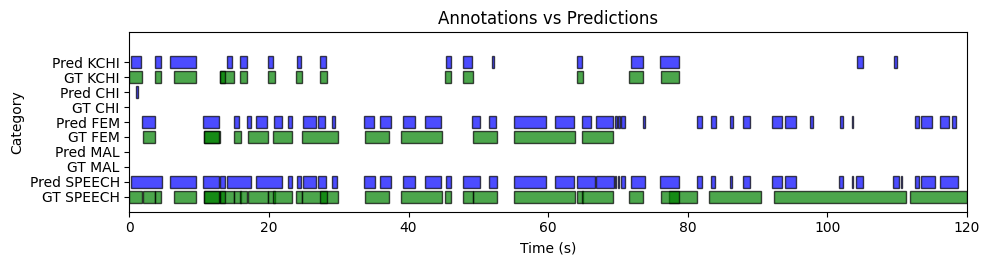

In [81]:
plot_annotations_vs_predictions('100898', "og", [0, 120])

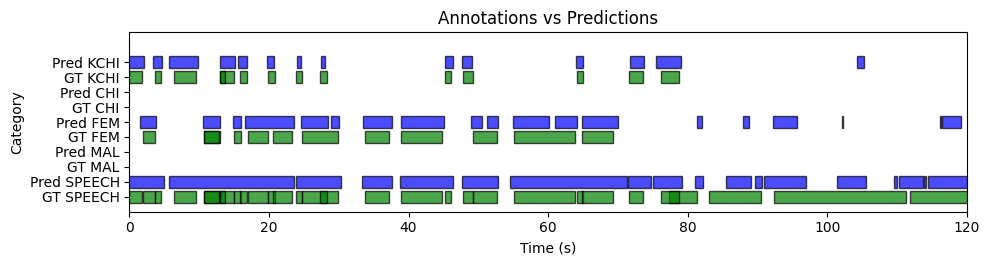

In [82]:
plot_annotations_vs_predictions('100898', "ft", [0, 120])

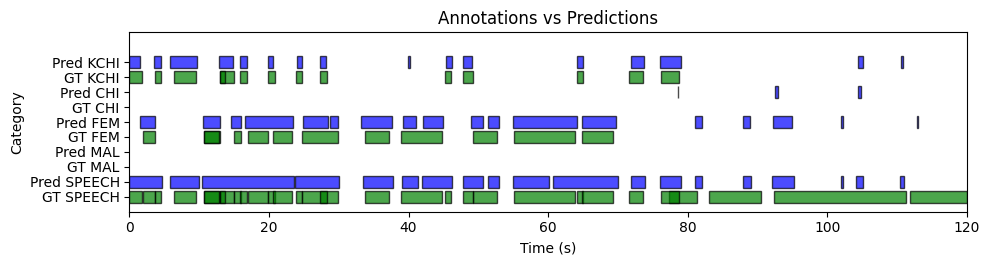

In [83]:
plot_annotations_vs_predictions('100898', "cl", [0, 120])

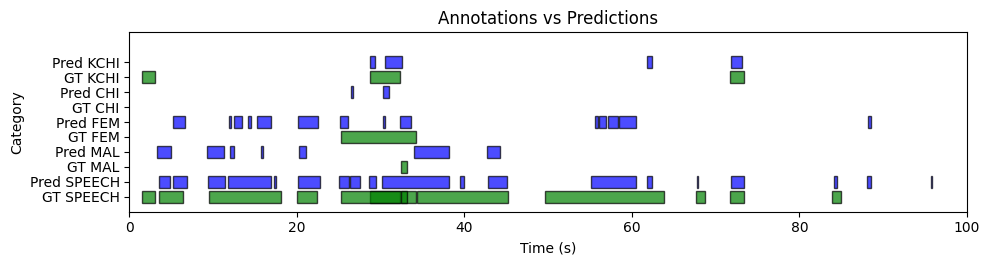

In [84]:
plot_annotations_vs_predictions('410731', "og", [0, 100])

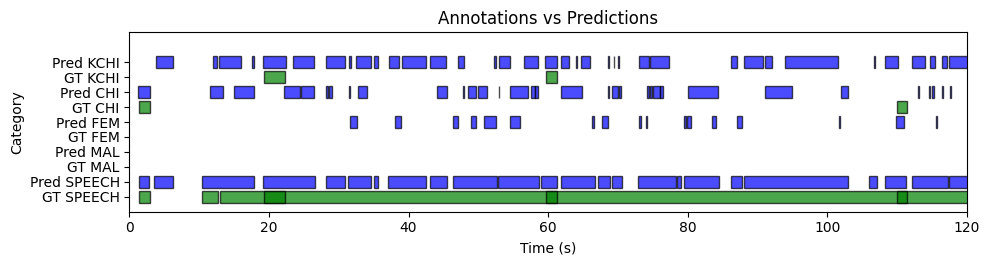

In [85]:
plot_annotations_vs_predictions('336244', "og", [0, 120])

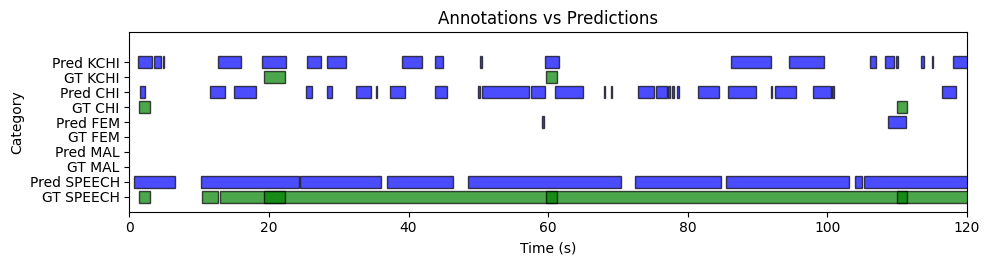

In [86]:
plot_annotations_vs_predictions('336244', "ft", [0, 120])

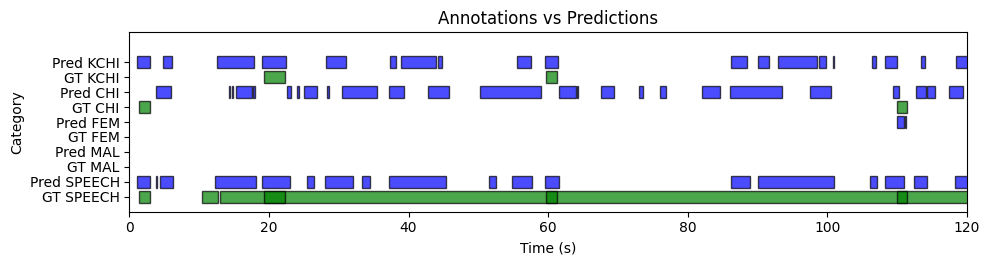

In [87]:
plot_annotations_vs_predictions('336244', "cl", [0, 120])

### Length of each Voice Type Class

In [88]:
gt_df = pd.read_pickle(VTCPaths.childlens_gt_df_file_path)
# sum utterance durations for each Voice_type in minutes (divide by 60)
gt_df.groupby('Voice_type')['Utterance_Duration'].sum() / 60

Voice_type
FEM        361.537183
KCHI       706.748417
MAL        176.754900
OCH         49.622783
SPEECH    1607.619517
Name: Utterance_Duration, dtype: float64

### Utils: Convert audio to 16khz sampling rate

In [ ]:
import os
from pathlib import Path
from pydub import AudioSegment
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

def convert_to_16khz(input_folder: Path, output_folder: Path) -> None:
    """Convert all audio files in a folder to 16kHz sampling rate.
    
    Parameters
    ----------
    input_folder : Path
        Path to folder containing audio files
    output_folder : Path
        Path where converted files will be saved
    """
    # Create output folder if it doesn't exist
    output_folder.mkdir(parents=True, exist_ok=True)
    
    # Supported audio formats
    audio_extensions = ('.wav', '.mp3', '.m4a', '.flac')
    
    # Get all audio files
    audio_files = [f for f in input_folder.iterdir() if f.suffix.lower() in audio_extensions]
    
    if not audio_files:
        logging.warning(f"No audio files found in {input_folder}")
        return
        
    for audio_file in audio_files:
        try:
            # Load audio file
            audio = AudioSegment.from_file(audio_file)
            
            # Convert to 16kHz
            audio_16k = audio.set_frame_rate(16000)
            
            # Create output path
            output_path = output_folder / f"{audio_file.stem}_16k{audio_file.suffix}"
            
            # Export converted audio
            audio_16k.export(output_path, format=output_path.suffix.replace('.', ''))
            
            logging.info(f"Converted: {audio_file.name}")
            
        except Exception as e:
            logging.error(f"Error converting {audio_file.name}: {e}")

if __name__ == "__main__":
    # Example usage
    input_folder = Path("/home/nele_pauline_suffo/ProcessedData/quantex_audio")
    output_folder = Path("/home/nele_pauline_suffo/ProcessedData/quantex_audio_16khz")
    
    convert_to_16khz(input_folder, output_folder)